# 📓 02_feature_engineering.ipynb

## Purpose  
Convert raw FIT/CSV exports → **ML-ready dataset**.  
### Extract per-run features  
- **Core**: pace, cadence, elevation, stride length, estimated GCT  
- **Advanced**: pace variability, cadence drift (fatigue indicator)  

### Compute aggregates  
- **Weekly mileage**  
- **Rolling 7d / 28d training load** (fitness vs fatigue proxy)  

### Save enriched features to  
`../data/processed/runs_summary_features.csv`  

---

## ⚠️ Note  

- **Notebook 1** → uses `runs_summary.csv` (basic cleaned data).  
- **Notebook 3+** → use `runs_summary_features.csv` (enriched dataset with biomechanics & training load).  

---

## 6. Progress Tracking & Records  

- Identify **fastest run** (lowest avg pace).  
- Identify **longest run** (highest distance).  
- Compute and visualize:  
  - **Rolling 7-day and 28-day training load**  
  - **Long-term trend of endurance and fatigue**  

In [10]:
# ---
# 02_feature_engineering.ipynb
# From raw FIT/CSV → ML-ready features
# ---

import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid", context="talk")

In [11]:
# -----------------------------
# 1. Load & Inspect Raw Data
# -----------------------------
interim_dir = Path("../data/interim")
files = list(interim_dir.glob("*.csv"))

print(f"Found {len(files)} raw runs")
if files:
    print("Example file:", files[0].name)

# Peek at first run (if available)
if files:
    preview = pd.read_csv(files[0], parse_dates=["timestamp"])
    display(preview.head())

Found 826 raw runs
Example file: 10011163869.csv


,altitude,cadence,distance,enhanced_altitude,enhanced_speed,fractional_cadence,position_lat,position_long,speed,timestamp,unknown_61,unknown_66
0,7.2,0,2.97,7.2,1.185,0.0,664554377,149690629,1.185,2023-06-25 14:27:27,2685,717
1,7.4,83,20.80,7.4,2.043,0.0,664555982,149692475,2.043,2023-06-25 14:27:33,2685,716
2,7.6,82,37.57,7.6,2.183,0.5,664557533,149694080,2.183,2023-06-25 14:27:39,2686,716
3,7.6,83,52.91,7.6,2.267,0.5,664558925,149695626,2.267,2023-06-25 14:27:45,2686,716
4,7.6,82,69.82,7.6,2.417,0.5,664560373,149697578,2.417,2023-06-25 14:27:51,2686,716


In [12]:
# -----------------------------
# 2. Helper Functions
# -----------------------------

def process_run(csv_path: Path):
    df = pd.read_csv(csv_path, parse_dates=["timestamp"])
    
    # Sort by time just in case
    df = df.sort_values("timestamp").reset_index(drop=True)
    
    # Compute deltas
    df["delta_time"] = df["timestamp"].diff().dt.total_seconds()
    df["delta_dist"] = df["distance"].diff()
    
    # Speed (m/s) → pace (min/km)
    if "enhanced_speed" in df.columns:
        df["pace_min_per_km"] = (1000 / df["enhanced_speed"]).replace([np.inf, -np.inf], np.nan) / 60
    else:
        df["pace_min_per_km"] = np.nan
    
    # Elevation gain
    if "enhanced_altitude" in df.columns:
        df["elev_gain"] = df["enhanced_altitude"].diff().clip(lower=0)
    else:
        df["elev_gain"] = 0
    
    # GPS conversion (Garmin semicircles → degrees)
    if "position_lat" in df.columns and "position_long" in df.columns:
        df["lat"] = df["position_lat"] * (180 / 2**31)
        df["lon"] = df["position_long"] * (180 / 2**31)
    
    # -----------------------------
    # Extra engineered features
    # -----------------------------
    
    # Pace variability (std deviation of pace within the run)
    pace_var = df["pace_min_per_km"].std() if "pace_min_per_km" in df else np.nan
    
    # Cadence drift (last quarter - first quarter)
    if "cadence" in df.columns and len(df) > 10:
        first_q = df["cadence"].iloc[: len(df) // 4].mean()
        last_q = df["cadence"].iloc[- len(df) // 4 :].mean()
        cadence_drift = last_q - first_q
    else:
        cadence_drift = np.nan
    
    # Stride length (speed * 60 / cadence)
    if "enhanced_speed" in df.columns and "cadence" in df.columns:
        stride_len_m = (df["enhanced_speed"] * 60 / df["cadence"]).mean()
    else:
        stride_len_m = np.nan
    
    # Estimated GCT (ms)
    if "cadence" in df.columns:
        gct_est = (30000 / df["cadence"]).mean()
    else:
        gct_est = np.nan
    
    # Fastest *sustained* segments
    min_pace = df["pace_min_per_km"].min()
    fastest_1km = np.nan
    fastest_5min = np.nan
    
    if "delta_dist" in df.columns and "pace_min_per_km" in df.columns:
        # rolling 1 km (accumulate distance)
        cum_dist = df["delta_dist"].cumsum()
        for i in range(len(df)):
            mask = (cum_dist >= cum_dist.iloc[i]) & (cum_dist <= cum_dist.iloc[i] + 1000)
            if mask.sum() > 10:
                seg_pace = df.loc[mask, "pace_min_per_km"].mean()
                if not np.isnan(seg_pace):
                    fastest_1km = min(fastest_1km, seg_pace) if not np.isnan(fastest_1km) else seg_pace
        
        # rolling 5 min
        window = int(300 / df["delta_time"].median()) if df["delta_time"].notna().any() else None
        if window and window > 1 and "pace_min_per_km" in df:
            fastest_5min = df["pace_min_per_km"].rolling(window).mean().min()
    
    # -----------------------------
    # Summary stats for this run
    # -----------------------------
    summary = {
        "run_id": csv_path.stem,
        "date": df["timestamp"].min().date() if "timestamp" in df else np.nan,
        "total_distance_km": df["distance"].max() / 1000 if "distance" in df else np.nan,
        "duration_min": df["delta_time"].sum() / 60 if "delta_time" in df else np.nan,
        "avg_pace_min_km": df["pace_min_per_km"].mean(),
        "min_pace_min_km": min_pace,
        "fastest_1km_pace": fastest_1km,
        "fastest_5min_pace": fastest_5min,
        "avg_cadence": df["cadence"].mean() if "cadence" in df.columns else np.nan,
        "total_elev_gain": df["elev_gain"].sum() if "elev_gain" in df else np.nan,
        "avg_stride_len_m": stride_len_m,
        "avg_gct_est_ms": gct_est,
        "pace_variability": pace_var,
        "cadence_drift": cadence_drift,
    }
    
    # Clean invalid values
    clean_summary = {}
    for k, v in summary.items():
        if isinstance(v, (int, float, np.number)):
            if pd.isna(v) or np.isinf(v):
                clean_summary[k] = np.nan
            else:
                clean_summary[k] = v
        else:
            clean_summary[k] = v
    
    return df, clean_summary

   



In [13]:
# -----------------------------
# 3. Process All Runs (Parallelized)
# -----------------------------
from joblib import Parallel, delayed
import multiprocessing

num_cores = multiprocessing.cpu_count()

def safe_process(f):
    try:
        return process_run(f)
    except Exception as e:
        print(f"⚠️ Error processing {f.name}: {e}")
        return None, None

# Run in parallel
results = Parallel(n_jobs=num_cores)(
    delayed(safe_process)(f) for f in files
)

# Collect results
all_summaries = []
all_runs = {}

for (df_run, summary), f in zip(results, files):
    if df_run is not None and summary is not None:
        all_runs[f.stem] = df_run
        all_summaries.append(summary)

summary_df = pd.DataFrame(all_summaries)

print(f"✅ Processed {len(all_summaries)} runs in parallel using {num_cores} cores")
summary_df.head()


✅ Processed 826 runs in parallel using 8 cores


,run_id,date,total_distance_km,duration_min,avg_pace_min_km,min_pace_min_km,fastest_1km_pace,fastest_5min_pace,avg_cadence,total_elev_gain,avg_stride_len_m,avg_gct_est_ms,pace_variability,cadence_drift
0,10011163869,2023-06-25,12.06647,56.550000,5.018505,3.301638,4.017123,4.017962,83.451356,94.4,NaN,NaN,11.731490,1.538462
1,10047123126,2023-07-01,8.35794,66.833333,6.946145,3.645378,3.911934,3.897595,81.568513,315.8,NaN,NaN,33.328740,5.272304
2,10049122762,2023-07-01,3.71447,95.916667,136.865433,8.387854,71.394383,23.026634,32.745813,172.4,NaN,NaN,327.712037,-9.478199
3,10075256002,2023-07-05,13.20205,67.700000,4.871706,3.645378,4.196892,4.197815,82.731469,153.8,NaN,NaN,0.932694,-0.629778
4,10100441652,2023-07-08,0.00000,52.550000,NaN,NaN,NaN,NaN,NaN,46.6,NaN,NaN,NaN,NaN


In [4]:
# -----------------------------
# 3. Process All Runs
# -----------------------------
all_runs = {}
all_summaries = []

for f in files:
    df_run, summary = process_run(f)
    all_runs[f.stem] = df_run
    all_summaries.append(summary)

summary_df = pd.DataFrame(all_summaries)
print("✅ Processed runs:", summary_df.shape[0])
display(summary_df.head())

✅ Processed runs: 826


,run_id,date,total_distance_km,duration_min,avg_pace_min_km,min_pace_min_km,fastest_1km_pace,fastest_5min_pace,avg_cadence,total_elev_gain,avg_stride_len_m,avg_gct_est_ms,pace_variability,cadence_drift
0,10011163869,2023-06-25,12.06647,56.550000,5.018505,3.301638,4.017123,4.017962,83.451356,94.4,NaN,NaN,11.731490,1.538462
1,10047123126,2023-07-01,8.35794,66.833333,6.946145,3.645378,3.911934,3.897595,81.568513,315.8,NaN,NaN,33.328740,5.272304
2,10049122762,2023-07-01,3.71447,95.916667,136.865433,8.387854,71.394383,23.026634,32.745813,172.4,NaN,NaN,327.712037,-9.478199
3,10075256002,2023-07-05,13.20205,67.700000,4.871706,3.645378,4.196892,4.197815,82.731469,153.8,NaN,NaN,0.932694,-0.629778
4,10100441652,2023-07-08,0.00000,52.550000,NaN,NaN,NaN,NaN,NaN,46.6,NaN,NaN,NaN,NaN


In [14]:
# -----------------------------
# 4. Feature Engineering (Aggregates)
# -----------------------------
summary_df = summary_df.sort_values("date")
summary_df["week"] = pd.to_datetime(summary_df["date"]).dt.to_period("W").apply(lambda r: r.start_time)

# Weekly aggregates
weekly = summary_df.groupby("week").agg({
    "total_distance_km": "sum",
    "duration_min": "sum",
    "avg_pace_min_km": "mean",
    "avg_cadence": "mean",
    "total_elev_gain": "sum"
}).reset_index()

# Rolling training load (7d, 28d)
summary_df["load_7d"] = summary_df["total_distance_km"].rolling(7, min_periods=1).sum()
summary_df["load_28d"] = summary_df["total_distance_km"].rolling(28, min_periods=1).sum()


In [15]:
# -----------------------------
# 5. Save Outputs
# -----------------------------
processed_dir = Path("../data/processed")
processed_dir.mkdir(exist_ok=True, parents=True)

# Final clean-up: replace any inf/-inf with NaN across the dataframe
summary_df = summary_df.replace([np.inf, -np.inf], np.nan)

# Save enriched session-level dataset
summary_path = processed_dir / "runs_summary_features.csv"
summary_df.to_csv(summary_path, index=False)

print(f"✅ Saved feature-enriched run summaries to {summary_path}")

# Check missing values
print("\n🔍 Missing values after cleaning:")
print(summary_df.isna().sum())


✅ Saved feature-enriched run summaries to ..\data\processed\runs_summary_features.csv

🔍 Missing values after cleaning:
run_id                 0
date                   0
total_distance_km      0
duration_min           0
avg_pace_min_km       96
min_pace_min_km       96
fastest_1km_pace      97
fastest_5min_pace    139
avg_cadence          102
total_elev_gain        0
avg_stride_len_m     384
avg_gct_est_ms       416
pace_variability      96
cadence_drift        103
week                   0
load_7d                0
load_28d               0
dtype: int64


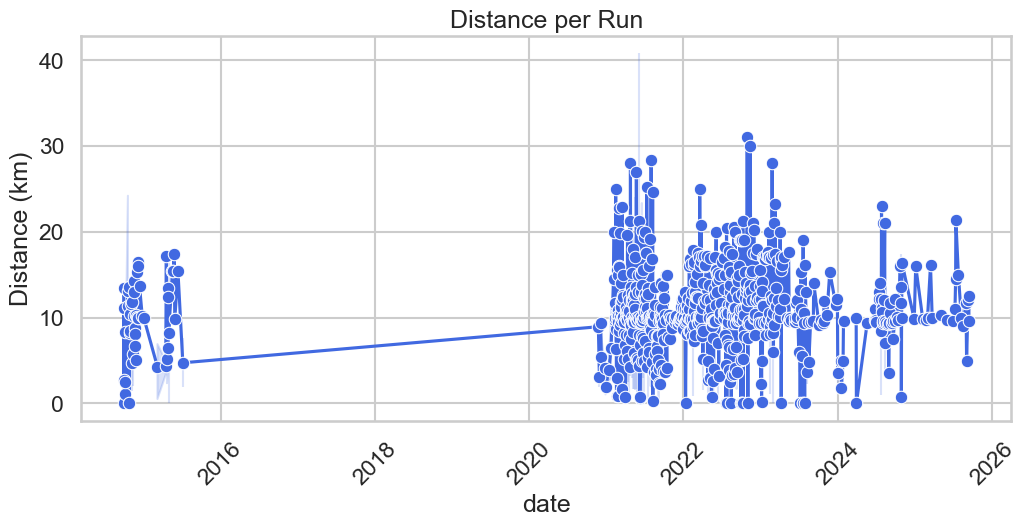

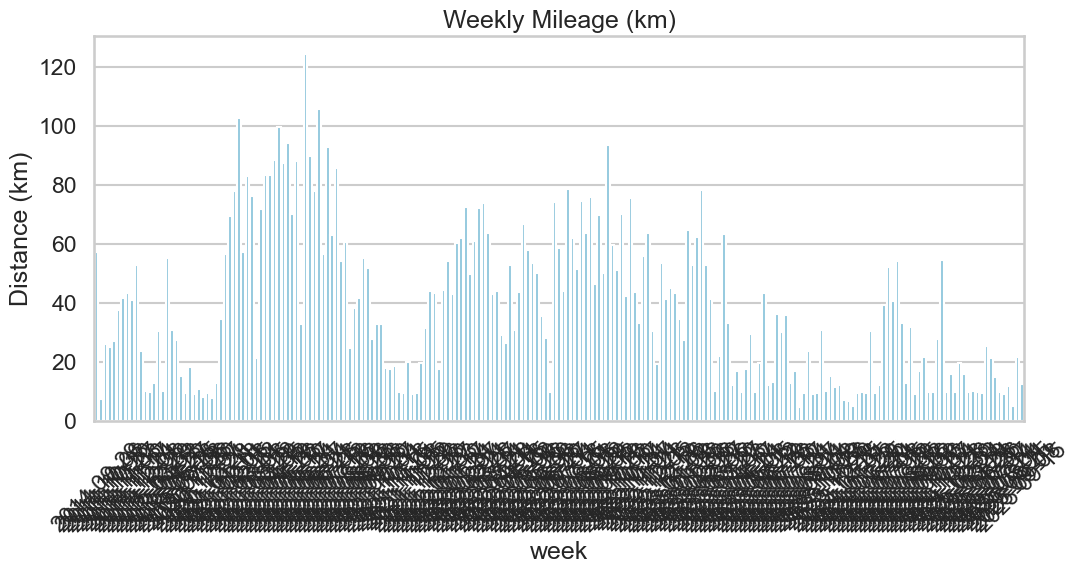

In [16]:
# -----------------------------
# 6. Visual Checks
# -----------------------------

plt.figure(figsize=(12,5))
sns.lineplot(data=summary_df, x="date", y="total_distance_km", marker="o", color="royalblue")
plt.title("Distance per Run")
plt.ylabel("Distance (km)")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(12,5))
sns.barplot(data=weekly, x="week", y="total_distance_km", color="skyblue")
plt.xticks(rotation=45)
plt.title("Weekly Mileage (km)")
plt.ylabel("Distance (km)")
plt.show()

🚀 Fastest run: 2021-08-24 1.82 min/km over 5.0 km
🏔️ Longest run: 2021-06-06 40.8 km in 203 min


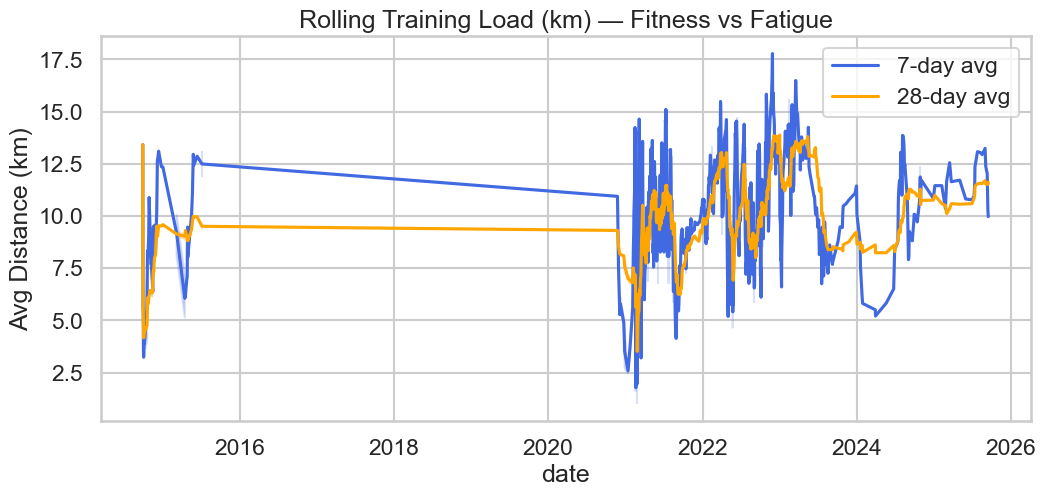

In [17]:
# -----------------------------
# 6. Progress Tracking & Records
# -----------------------------

# Fastest run (lowest average pace)
fastest_run = summary_df.loc[summary_df["avg_pace_min_km"].idxmin()]
print("🚀 Fastest run:", fastest_run["date"], 
      f"{fastest_run['avg_pace_min_km']:.2f} min/km over {fastest_run['total_distance_km']:.1f} km")

# Longest run (max distance)
longest_run = summary_df.loc[summary_df["total_distance_km"].idxmax()]
print("🏔️ Longest run:", longest_run["date"], 
      f"{longest_run['total_distance_km']:.1f} km in {longest_run['duration_min']:.0f} min")

# Rolling averages (fitness vs fatigue proxy)
summary_df = summary_df.sort_values("date")
summary_df["rolling_7d_km"] = summary_df["total_distance_km"].rolling(7, min_periods=1).mean()
summary_df["rolling_28d_km"] = summary_df["total_distance_km"].rolling(28, min_periods=1).mean()

# Plot rolling load (7-day vs 28-day average distance)
plt.figure(figsize=(12,5))
sns.lineplot(data=summary_df, x="date", y="rolling_7d_km", label="7-day avg", color="royalblue")
sns.lineplot(data=summary_df, x="date", y="rolling_28d_km", label="28-day avg", color="orange")
plt.title("Rolling Training Load (km) — Fitness vs Fatigue")
plt.ylabel("Avg Distance (km)")
plt.legend()
plt.show()


In [18]:
# -----------------------------
# 7. Training Insights (Auto-Summary)
# -----------------------------

def training_insights(summary_df):
    insights = []

    # Fastest run
    if "avg_pace_min_km" in summary_df.columns:
        fastest = summary_df.loc[summary_df["avg_pace_min_km"].idxmin()]
        insights.append(
            f"🚀 Fastest run: {fastest['date']} — "
            f"{fastest['avg_pace_min_km']:.2f} min/km over {fastest['total_distance_km']:.1f} km"
        )

    # Longest run
    if "total_distance_km" in summary_df.columns:
        longest = summary_df.loc[summary_df["total_distance_km"].idxmax()]
        insights.append(
            f"🏔️ Longest run: {longest['date']} — "
            f"{longest['total_distance_km']:.1f} km in {longest['duration_min']:.0f} min"
        )

    # Rolling load patterns
    if "rolling_7d_km" in summary_df.columns and "rolling_28d_km" in summary_df.columns:
        avg_7d = summary_df["rolling_7d_km"].mean()
        avg_28d = summary_df["rolling_28d_km"].mean()

        if avg_7d > avg_28d:
            insights.append("📈 Recent training load is higher than long-term base — possible peak phase.")
        else:
            insights.append("📉 Training load is steady or slightly below long-term base — consistent base building.")

    # Output insights
    print("\n".join(insights))

# Run auto-summary
training_insights(summary_df)


🚀 Fastest run: 2021-08-24 — 1.82 min/km over 5.0 km
🏔️ Longest run: 2021-06-06 — 40.8 km in 203 min
📈 Recent training load is higher than long-term base — possible peak phase.
